# Feature Selection ⚙️

In [2]:
#Name: Soohoon Oh
#Contact: soohoonoh@wustl.edu
#Sources from Washu CSE217a course materials

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utility.util import configure_plots

# run this twice!
configure_plots()

In [5]:
configure_plots()

## 1. Loading and Preparing the Data

First, we will load the breast cancer dataset and its 30 features. Since we want to **simulate** what happens when we have too many features, many of which are redundant or are just noise. Let's add 30 features that are random noise. We will call the resulting dataset the original data. 

In [53]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

noise = np.random.RandomState(28).normal(size=X.shape)
X_noise = np.hstack([noise,X])


### Creating Training, Validation, and Testing Sets

We then split the data into test and train sets, as well as an additional validation set to compare the final results of the models generated.

**Try this!** In the following cell, produce a test set with 20% of the `X_noise`, then use 20% of the remaining data as a validation set. The data left will be our training set. Stratify by the target variable (remember how this data set was unbalanced). Also, use a `random_state` of 13.

In [69]:
from sklearn.model_selection import train_test_split

X_trainval,X_test,y_trainval, y_test=train_test_split(X_noise,y,test_size=0.2,random_state=42, stratify=y)
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval,test_size=0.2,random_state=42,stratify=y_trainval)



assert X_train.shape[0]==364, 'You seem to be creating the wrong TR, VAl, TE splits'
assert X_test.shape[0]==114, 'You seem to be creating the wrong TR, VAl, TE splits'
assert X_val.shape[0]==91, 'You seem to be creating the wrong TR, VAl, TE splits'

## 2. Model-Based Feature Selection

In model-based feature selection, a model (that could be different from the one used for predictions) selects the features that are most important by accounting for interactions between features as well - unlike statistical methods that mainly only look at features individually.

In the following we will use a random forestclassifier with 100 trees to compute the feature importance for our given data. 

### Selecting the Most Important Features

**Try this!** Complete the following `get_RF_mask()` function, that takes a data set (`X_in` and `y_in`), fits a provided model on that training data, and gets the feature importance scores from the fitted model. Store the feature importance scores in a variable called `importance` and create a Boolean mask called `mask` that can be used to select all features for which `importance` is above the _median importance_.

> **Hint:** The random forest model has a `feature_importances_` attribute. 

In [70]:
def get_RF_mask(X_in,y_in, model_in):
    
    importance = None
    mask = None

    #check if model_in is a RF model
    assert hasattr(model_in, 'n_estimators'), 'Your model is not a random forest model: use a RandomForestClassifier or RandomForestRegressor model!' 
    model_in.fit(X_in,y_in)
    importance=model_in.feature_importances_
    mask=importance>np.median(importance)
    
  

    
    return mask

Now, we can initialize a a random forest classifier and call this `get_RF_mask()` function on the model and our training data. 

In [71]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=28)

rf_mask = get_RF_mask(X_train, y_train, model)
X_train_selected = X_train[:,rf_mask]
print(f'     All Features: {X_train.shape}')
print(f'Selected Features: {X_train_selected.shape}')

assert X_train_selected.shape[1]==30, 'You seem to have the wron number of features selected.'

     All Features: (364, 60)
Selected Features: (364, 30)


To see what has been selected, we can plot an array of the indices of the features. A black index indicates a selected feature.

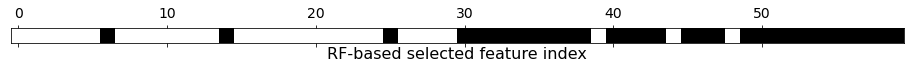

In [72]:
plt.matshow(rf_mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("RF-based selected feature index")
plt.yticks(())
plt.show()

**Write-up** Compare the selected features with the way we created the inputs `X_noise` for this lab. Does the result of the random-forest based feature selector we implemented make sense?  

**Your response here:**  It's somewhat accurate. Most features from the dataset are selected. Maybe the dataset has some features that are not important


### Comparing the Model Performance (RF-Selected vs All Features)

Let's test the original set of features and the selected ones to see the difference, using a logistic regression.


#### On the Test Set

**Try this!** Create a function `get_LR_score()` that intantiates a `LogisticRegression` model and fits it with the provided training data (`X_tr`, `y_tr`). Evaluate the model on the test set (`X_te`, `y_te`) using accuracy as evaluation metric and return the result. Set the solver for the logistic regression model to be `liblinear` and  use a `random_state` of 15.

Then, we will call this function using all features (the original and nosiy features) to get a baseline test accuracy score.  

In [73]:
from sklearn.linear_model import LogisticRegression

def get_LR_score(X_tr, y_tr,X_te, y_te):
    
    model=LogisticRegression(solver='liblinear',random_state=15)
    model.fit(X_tr,y_tr)
    y_pred=model.predict(X_te)
    accuracy=len(y_pred[y_pred==y_te])/len(y_pred)
    return accuracy


    
noisy_score = get_LR_score(X_train, y_train, X_test, y_test)
print(f'test accuracy score for all features (including noisy features): {noisy_score:0.4f}')

test accuracy score for all features (including noisy features): 0.9298


**Try this!** Now, lets get a test accuracy score using the selected features. Call `get_LR_score()` with the feature-selected training set `X_train_selected` and an appropriate `X_test_selected`. 

> **Hint:** Use `rf_mask` to create `X_test_selected` by masking the noisy test set. 

In [74]:
selected_score = None

X_test_selected=X_test[:,rf_mask]
selected_score=get_LR_score(X_train_selected,y_train,X_test_selected,y_test)

    
print(f'test accuracy score for RF-selected selected features: {selected_score:0.4f}')

test accuracy score for RF-selected selected features: 0.9649


**Write-up:** What is the test set performance for the two approaches? Which approach performs better using **all features** or using only the **selected features**? 

**Your response here:** 


#### Doing Cross-Validation

Since we've learned that there are shortcomings with evaluations that use only one fixed test set, let's investigate the performance of RF-based feature selection via cross-validataion.   

**Try this!** Complete the following cell implementing cross-validation. Use the `get_LR_score()` and `get_RF_mask()` functions  you implemented above with their appropriate input arguments. 

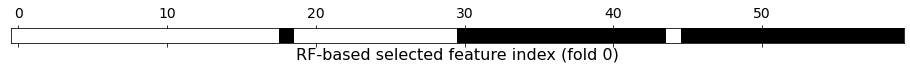

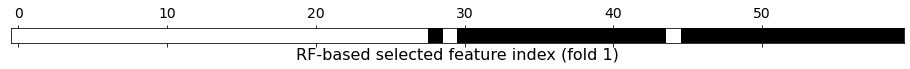

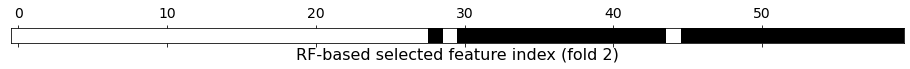

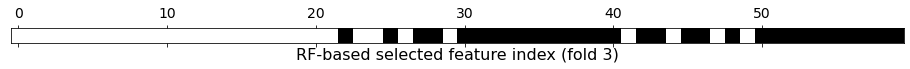

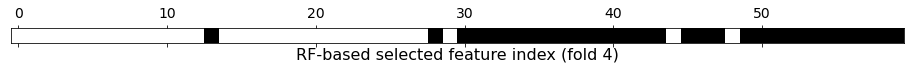

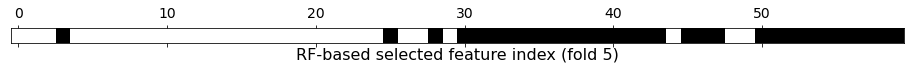

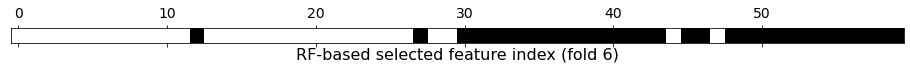

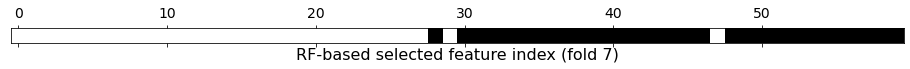

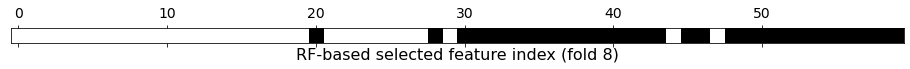

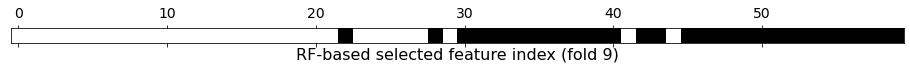

In [75]:
from sklearn.model_selection import KFold

kf = KFold(10, shuffle=True, random_state=1)
noisy_scores = np.zeros(10)
selected_scores = np.zeros(10)

for fold, (train_idx, test_idx) in enumerate(kf.split(X_noise)):
    
    X_train_fold, y_train_fold = X_noise[train_idx], y[train_idx]
    X_test_fold, y_test_fold = X_noise[test_idx], y[test_idx]
    
    
    noisy_scores[fold]=get_LR_score(X_train_fold,y_train_fold,X_test_fold,y_test_fold)
    
    # get RF-mask using training portion of fold
    model_fold = RandomForestClassifier(n_estimators=100, random_state=28)
    
    # your code here 
    rf_mask_fold=get_RF_mask(X_train_fold,y_train_fold,model_fold)
    
    
    plt.matshow(rf_mask_fold.reshape(1, -1), cmap='gray_r')
    plt.xlabel("RF-based selected feature index (fold "+str(fold)+")")
    plt.yticks(())
    plt.show()
    
    #apply mask to fold
    X_train_fold_selected = X_train_fold[:,rf_mask_fold]
    X_test_fold_selected  = X_test_fold[:,rf_mask_fold]
  
    # get selected score for fold
    # your code here 
    selected_scores[fold]=get_LR_score(X_train_fold_selected,y_train_fold,X_test_fold_selected,y_test_fold)


**Write-up:** Note that every fold uses a **different** training set. This means that `get_RF_mask()` may select differnt features for each of the different folds. For this particular experiment we just ran, did we get different sets of selected features for the different folds? 

**Your response here:**  Yes. 


### Visualizing Cross-Validation Results

Since we now used cross-valitation quite a bit in this course, let's look at how we can visualiza the CV results. We will introduce two ways: boxplots and line plots. 

> **Note:** This section is not just for feature selection, but you can use this anytime you perform cross-validation to better understand the evaluatuion resutls, for inteance the variance of the performance results between folds!

#### Boxplot

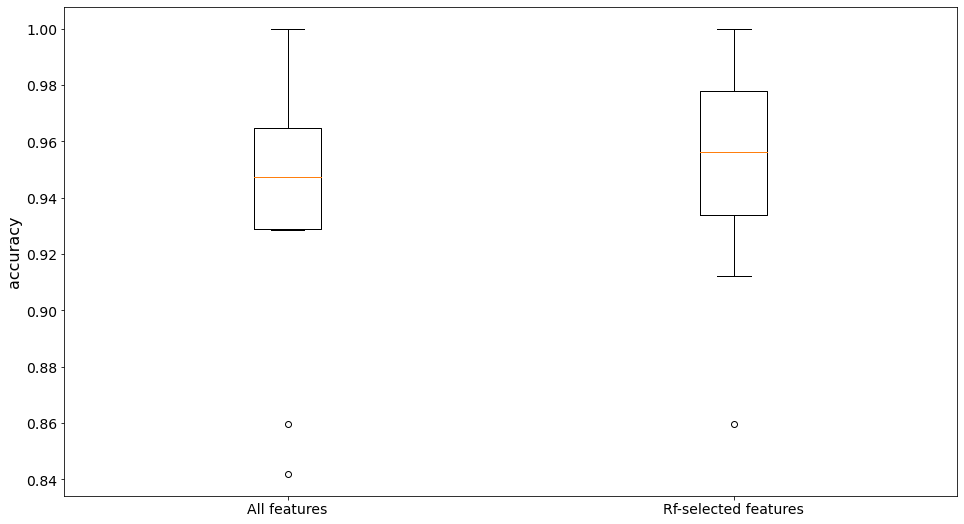

All median accuracy: 94.74
RF-selected median accuracy: 95.61


In [76]:
import matplotlib.pyplot as plt

plt.boxplot([noisy_scores, selected_scores])

plt.xticks([1, 2], ["All features", "Rf-selected features"])
plt.ylabel("accuracy")
plt.show()
   
print(f"All median accuracy: {np.round(100*np.median(noisy_scores),2)}") 
print(f"RF-selected median accuracy: {np.round(100*np.median(selected_scores),2)}") 

#### Direct Comparison via Line Plot

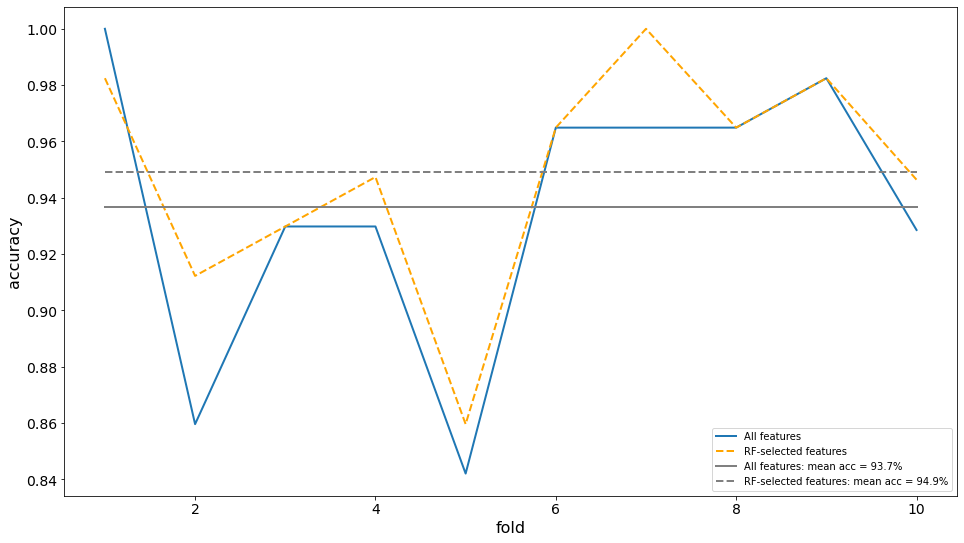

All mean accuracy: 93.67
RF-selected mean accuracy: 94.9


In [77]:
plt.plot(range(1,11),noisy_scores, label="All features")
plt.plot(range(1,11),selected_scores, '--', color='orange', label="RF-selected features")

plt.plot(range(1,11),np.tile(np.mean(noisy_scores),10), c ="gray", 
         label="All features: mean acc = " + str(np.round(100*np.mean(noisy_scores),1))+"%")

plt.plot(range(1,11),np.tile(np.mean(selected_scores),10), '--', c ="gray", 
         label="RF-selected features: mean acc = " + str(np.round(100*np.mean(selected_scores),1))+"%")

plt.ylabel("accuracy")
plt.xlabel("fold")
plt.legend(loc="lower right")
plt.show()

print(f"All mean accuracy: {np.round(100*np.mean(noisy_scores),2)}") 
print(f"RF-selected mean accuracy: {np.round(100*np.mean(selected_scores),2)}") 

**Write-up:** Describe your plots and decide whether all features or selected features perform better. Justify your choice. 

**Your response here:**  The selected features performed better.


## 3. Iterative Feature Selection

Next, we will explore preformance-based feature selection. The strategies in this family are also referred to as _wrapper_ or _filter_ approaches since they need a ML method that gets trained and evaluated for various differnt feature sets during the selection process. 

In iterative feature selection, we remove or build up one feature at a time, as opposed to constructing one model from which the entire selection is made. A particular kind of this feature selection strategy is [**recursive feature elimination** (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), which starts with all features, builds and evaluates a model, then builds and evaluates a model for each dataset revoing ine feature at a time. It then discards the feature whose removal lead to the largest performance according to the model (evaluated on the valitaion set). Then a new model is built using all but the discarded feature, and we eliminate the next feature using the same strategy and so on until only a prespecified number of features are left. Here, we use the logistic regression model as classifier.

In this code, we will run RFE, selecting 59 of the 60 features, then 58, and so on, until only 1 remains. At this point, we expect the accuracy to be somewhat lower, given that we would have to get rid of some of the original 30 features. We also save the remaining features at every iteration so that we can make a choice on which set to use going forward without having to do any recomputations.

> **Note:** We use our friends the Boolean indicator vectors (_masks_) to store the different feature sets for each iteration. 

In [78]:
import sklearn 
print(f'sklearn: {sklearn.__version__}')

import scipy
print(f'scipy: {scipy.__version__}')

import warnings
if scipy.__version__!="1.5.2":
    warnings.warn("Warning: you might get differnt results than expected. We need scipy 1.5.2 for this to work properly.")
    
if sklearn.__version__!="0.23.2":
    warnings.warn("Warning: you might get differnt results than expected. We need sklearn 0.32.2 for this to work properly.")

sklearn: 0.23.2
scipy: 1.5.2


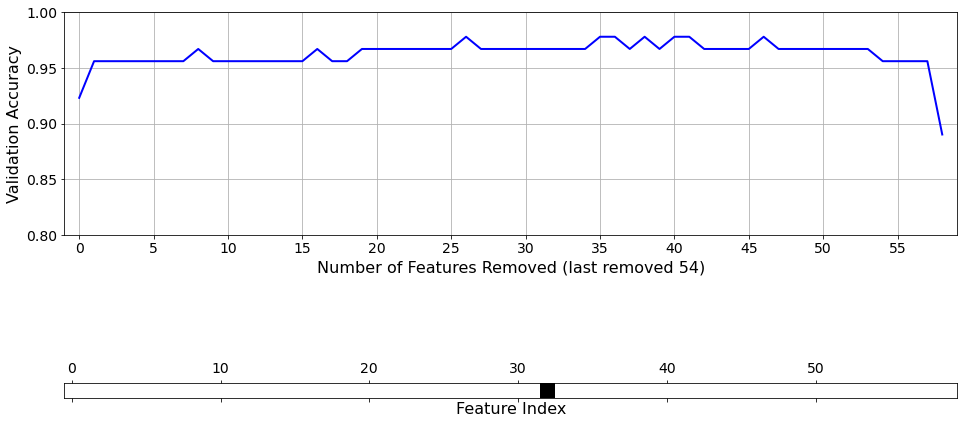

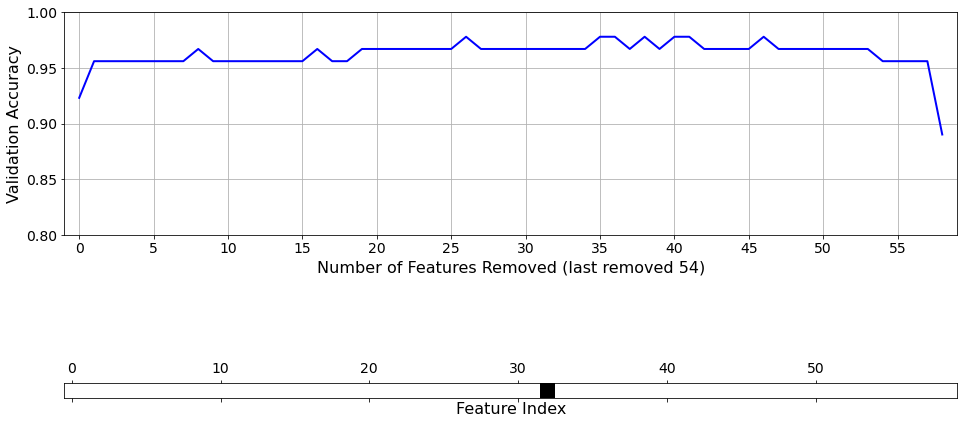

In [89]:
from IPython import display
import warnings
warnings.filterwarnings('ignore')

scores, masks = [],[]

# save all the masks as we remove features
curr_mask = [*range(0,X_train.shape[1]-1)]
mask = np.zeros((X_train.shape[1],), bool)
mask[curr_mask] = True
masks.append(mask)

#set up axes for plot
fig, (ax1, ax2) = plt.subplots(2, 1)

# compute scores on D_VAL for all features
scores.append(get_LR_score(X_train, y_train,X_val, y_val))

#model = LogisticRegression(solver='newton-cg')   #(solver='lbfgs', random_state=42)  
#model.fit(X_train,y_train)
#scores.append(model.score(X_val, y_val))

# iterate over fetures to remove
for i in range(X_train.shape[1]-2):

    perf = np.zeros((len(curr_mask),))
    
    for j, idx in enumerate(curr_mask):
        ind = curr_mask.copy()
        ind.remove(idx)
        model.fit(X_train[:,ind],y_train)

        perf[j]=model.score(X_val[:,ind], y_val)
    max_perf = np.max(perf)
    scores.append(max_perf)
    
    feat_to_remove = curr_mask[np.argmax(perf)]
    #print(f"removing {feat_to_remove}")
    
    curr_mask.remove(feat_to_remove)

    mask = np.zeros((X_train.shape[1],), bool)
    mask[curr_mask] = True
    masks.append(mask)

    # update plot
    ax1.clear()
    ax1.plot(scores, 'b-')
    ax1.grid()
    ax1.set_xlim(-1, X_train.shape[1]-1)
    ax1.set_ylim(0.80, 1)
    ax1.set_xticks(np.arange(0,X_train.shape[1],5))
    ax1.set_xlabel('Number of Features Removed (last removed '+str(feat_to_remove)+')')
    ax1.set_ylabel('Validation Accuracy')

    ax2.matshow(mask.reshape(1, -1), cmap='gray_r')
    ax2.set_yticks(())
    ax2.set_xlabel('Feature Index')
    
    display.clear_output(wait=True)
    display.display(fig)

### Selecting the Best Performing Features

**Write-up!** Given the plots produced above, how many features should we remove using the RFE algorithm? Why? Additionally, why does each successive iteration run faster than the previous one?

**Your response here:** 26


**Do this!** In the cell below, store the mask from `masks` from the iteration number that you chose above in `RFE_mask`. We will plot the features selected during this iteration.

([], [])

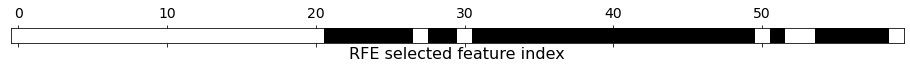

In [101]:
rfe_mask=masks[26]


plt.matshow(rfe_mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("RFE selected feature index")
plt.yticks(())

### Comparing the Model Performance (RFE-Selected vs All Features)

#### On the Test Set

**Do this!**  Use the best set of features to train a `LogisticRegression` model. Then, evaluate it with the respective test set and report the result.

> **Hint:** Reuse your `get_LR_score()` function you implemented earlier. 

In [102]:
X_tr=X_train[:,rfe_mask]
X_te=X_test[:,rfe_mask]
RFE_score=get_LR_score(X_tr,y_train,X_te,y_test)




We leave the cross-validation based evaluation as an excercise for the curious! 

## 4. Comparing Feature Selection Strategies 

Now, lets compare our two strategies to select features: _model-based feature selection_ using **random forests** (RF) vs. _performance-based feature selection_ using **recursive feature elimination** (RFE). 

In [103]:
print(f'test accuracy score for all 60 features (including noisy features): {noisy_score:0.4f}')
print(f'test accuracy score for the {sum(rf_mask)} RF-selected selected features: {selected_score:0.4f}')
print(f'test accuracy score for the {sum(rfe_mask)} RFE-selected features: {RFE_score:0.4f}')

test accuracy score for all 60 features (including noisy features): 0.9298
test accuracy score for the 30 RF-selected selected features: 0.9649
test accuracy score for the 33 RFE-selected features: 0.9474


**Write-up!** Answer the following questions comparing the RF and the RFE strategies. 
* How did the resulting, feature-selected, datasets perform relative to the original one? 
* Which feature selection method performs better? 
* What are the pros and cons of each feature selection method? Thing about runtime performance, used datasets, etc.
* Is there one that you should prefer over the other?

**Your response here:** 


## Take away!

As you can see, feature selection has a generally positive impact on this data set, given that we added 30 extra features of noise. Here we used a linear model for predictions. Note that **efficiency considerations** are far more relevant for _more complex models_ and especially models that _use the training datset in the prediction phase_ such as k-NN.

Feature selection is definitley a tool you should keep in mind when doing both **runtime and performance engineering** for machien leanring algorithmns. 
It also is a good tool to keep in mind for combatting _overfitting_. But, beware that removing too many features could have a negative impact on the performance for new unseen test data too.

## [optional] 5. Demo: Applying Feature Selection for Rideshare Price Prediction

Now, if you still have time and energy, look at a (familiar) real-world dataset and how feature selection can help in understanding and visualizing the data as well as for doing predicitve modelling. 

<img src="utility/pics/rideshare.png" alt="rideshare" style="width: 600px;"/>



Copy the raw data over form your `hw6` folder or download it from here: https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma Makre sure you save it under `utility/data` in your Lab9 folder. 

In [1]:
import pandas as pd

df = pd.read_csv("utility/data/rideshare_kaggle.csv")
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [2]:
df = df.dropna()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df.select_dtypes(include=numerics)
newdf = newdf.drop(columns=['price'])
newdf.head()

,timestamp,hour,day,month,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,1.544953e+09,9,16,12,0.44,1.0,42.2148,-71.033,42.34,37.12,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,1.543284e+09,2,27,11,0.44,1.0,42.2148,-71.033,43.58,37.35,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,1.543367e+09,1,28,11,0.44,1.0,42.2148,-71.033,38.33,32.93,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,1.543554e+09,4,30,11,0.44,1.0,42.2148,-71.033,34.38,29.63,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,1.543463e+09,3,29,11,0.44,1.0,42.2148,-71.033,37.44,30.88,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


(637976, 45)
(637976,)


(array([2.69805e+05, 1.84912e+05, 1.30154e+05, 4.38570e+04, 7.21500e+03,
        1.44000e+03, 4.08000e+02, 9.00000e+01, 7.30000e+01, 2.20000e+01]),
 array([ 2.5, 12. , 21.5, 31. , 40.5, 50. , 59.5, 69. , 78.5, 88. , 97.5]),
 <BarContainer object of 10 artists>)

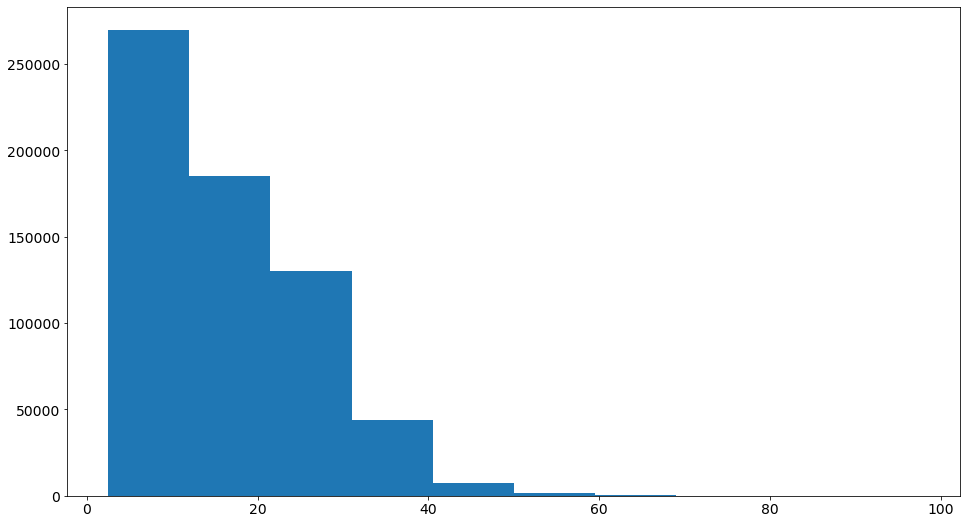

In [6]:
X_rideshare = newdf.to_numpy()
X_cols = newdf.columns # remember the column names for later 
y_rideshare = df.price

print(X_rideshare.shape)
print(y_rideshare.shape)
plt.hist(y_rideshare)

In [7]:
from sklearn.model_selection import train_test_split

X_rideshare_rest, X_rideshare_test, y_rideshare_rest, y_rideshare_test = train_test_split(X_rideshare, 
                                                            y_rideshare, random_state=53, test_size=0.2)
X_rideshare_train, X_rideshare_val, y_rideshare_train, y_rideshare_val = train_test_split(X_rideshare_rest, 
                                                            y_rideshare_rest, random_state=53, test_size=0.2)

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10, random_state=28, max_depth=5)

model.fit(X_rideshare_train, y_rideshare_train)

# get importance
importance = model.feature_importances_

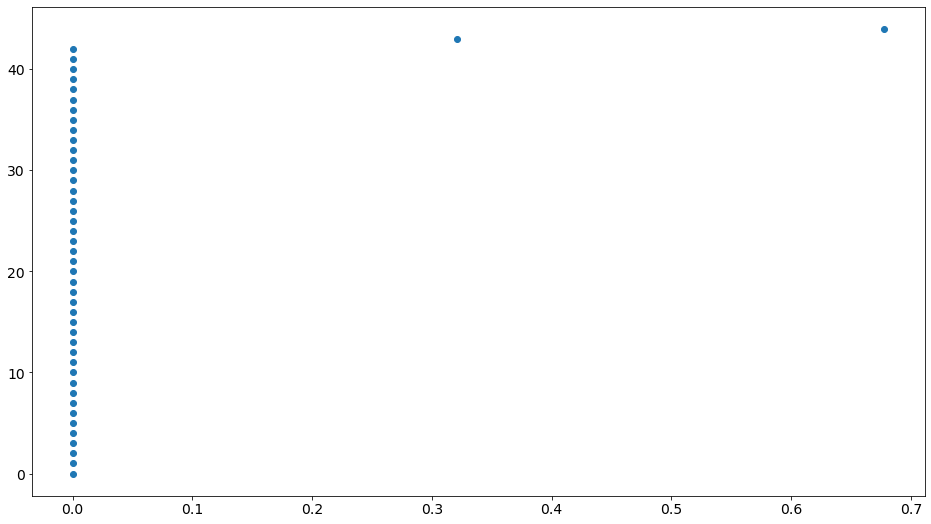

In [9]:
plt.scatter(np.sort(importance),np.arange(importance.shape[0]))

That's amazing: it turns out from all the continuous features available only 2 seem to have an importance score larger than 0. So, let's use only these two features for price prediction. 

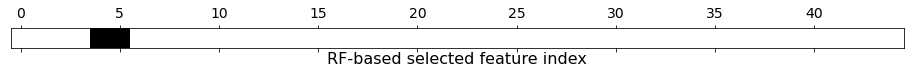

In [10]:
mask_rideshare = importance>np.quantile(importance, 0.97)
plt.matshow(mask_rideshare.reshape(1, -1), cmap='gray_r')
plt.xlabel("RF-based selected feature index")
plt.yticks(())
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression

all_model = LinearRegression()
all_model.fit(X_rideshare_train, y_rideshare_train)
print(f'val r_squared score for original data (including all features): {all_model.score(X_rideshare_val, y_rideshare_val):0.4f}')

val r_squared score for original data (including all features): 0.1712


In [12]:
from sklearn.linear_model import LinearRegression

selected_model = LinearRegression()

X_rideshare_train_selected = X_rideshare_train[:,mask_rideshare]
X_rideshare_val_selected = X_rideshare_val[:,mask_rideshare]

selected_model.fit(X_rideshare_train_selected, y_rideshare_train)
print(f'val r_squared score for RF-selected features: {selected_model.score(X_rideshare_val_selected, y_rideshare_val):0.4f}')

val r_squared score for RF-selected features: 0.1712


### Visualization

Since we have only two features that really contribute to our prediciton, we can now visualize the relationship in a series of 2D and 3D (!!) plots. 

In [13]:
# data for 3D scatter points
zdata = selected_model.predict(X_rideshare_val_selected)
xdata = X_rideshare_val[:,np.where(mask_rideshare)[0][0]]
ydata = X_rideshare_val[:,np.where(mask_rideshare)[0][1]]

x_label = X_cols[np.where(mask_rideshare)[0][0]]
y_label = X_cols[np.where(mask_rideshare)[0][1]]

/opt/anaconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
/opt/anaconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


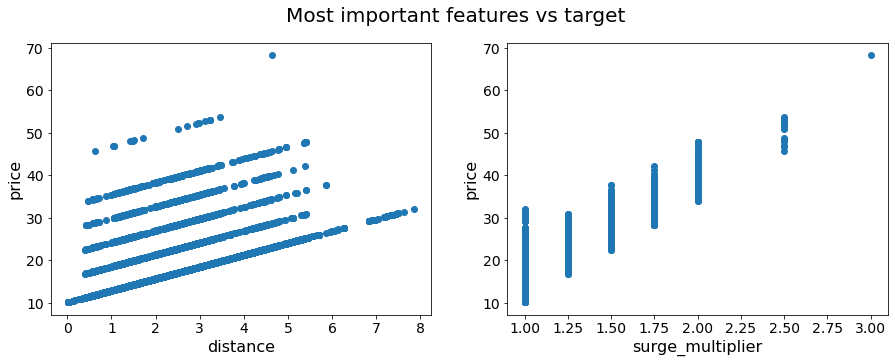

In [14]:
# let's do 2D plots first
plt.figure(figsize=(15, 5))        
plt.suptitle("Most important features vs target", fontsize=20)

# an example of a plot for the 'Gender' feature
plt.subplot('121')
plt.scatter(xdata,zdata)
plt.xlabel(x_label)
plt.ylabel("price")

plt.subplot('122')
plt.scatter(ydata,zdata)
plt.xlabel(y_label)
plt.ylabel("price")
plt.show()

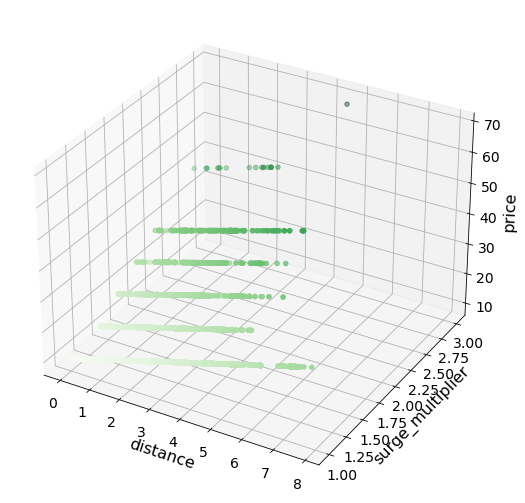

In [15]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zlabel('price');

# get a different view
#ax.view_init(60, 35)

[**optional**] This is an interactive viewer you can also play with: 

> Install: `pip install plotly`